In [1]:
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))

In [2]:
import torch as torch
from torch.distributions import MultivariateNormal
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
# import parametric_pushforward.parametric_ode_solvers

import numpy as np 
import matplotlib.pyplot as plt

import parametric_pushforward.data_sets as toy_data
from parametric_pushforward.parametric_mlp import order_state_to_tensor
from parametric_pushforward.visualization import path_visualization, path_visualization_with_trajectories,display_bds,create_particle_animation
from parametric_pushforward.spline import Assemble_spline
from parametric_pushforward.setup_density_path_problem import load_boundary_models,get_activation,opinion_dynamics_setup,get_potential_functions
from reference_solutions.gaussian_solutions import estimate_mean_cov,W2_gaussian,l2_uvp,test_results_gaussian_SB,monge_map,monge_map_torch

import os
import yaml


cuda:3
Successfully patched Parametric_Euler and Parametric_Midpoint
Successfully patched Parametric_Euler and Parametric_Midpoint
/work/Sebas/Density_Path_Opt/Parametric_pushforward


In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)

In [4]:
# name of experiment
exp_dir = str(root_path)+ '/experiments/gaussian0_d_to_gaussian1_d_pot_geodesic_fisher_information_20250427_193009'
yaml_path = os.path.join(exp_dir, 'config.yaml')
with open(yaml_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [5]:

name_data0 = config['data']['source']['name']
checkpt0 = 'final'#'checkpoint_1999'
name_data1 = config['data']['target']['name']
checkpt1 = 'final'#'checkpoint_1999'

arch_dims = [config['architecture']['input_dim'],config['architecture']['hidden_dim'],config['architecture']['num_layers']]
activation = get_activation(config['architecture']['activation'])

arch = arch_dims+[activation]

spline_type = config['spline']['type']


prior = MultivariateNormal(torch.zeros(config['architecture']['input_dim']).to(device),torch.eye(config['architecture']['input_dim']).to(device))

state0,state1 = load_boundary_models(config,device)
theta0 = order_state_to_tensor(state0)
theta1 = order_state_to_tensor(state1)

ke_modifier = None


In [6]:
# Build spline
num_collocation = config['spline']['num_collocation']
spline0,t = Assemble_spline(theta0=theta0,
                            theta1=theta1,
                            arch=arch,
                            data0=name_data0,
                            data1=name_data1,
                            ke_modifier=ke_modifier,
                            potential=get_potential_functions(config['potential_functions']),
                            number_of_knots=num_collocation,
                            spline=spline_type,
                            device = device,
                            prior_dist=prior)

spline0.sigma = config['coefficients_potentials']['sigma']


In [7]:

spline_path = os.path.join(exp_dir, 'checkpoints/spline.pth') #geo_initial / initial / spline
try:
    state_spline0 = torch.load(spline_path,map_location=device)#['ema_model']
    spline0.load_state_dict(state_spline0)
except:
    state_spline0 = torch.load(spline_path,map_location=device)['ema_model'] #direct_model #ema_model
    spline0.load_state_dict(state_spline0)

spline0.eval()
print(spline0.sigma)

1.0


In [8]:
samples = 5000
t_node = 10
x0 = torch.from_numpy(toy_data.inf_train_gen(name_data0, batch_size=samples,dim = config['architecture']['input_dim'])).float().to(device)
x1 = torch.from_numpy(toy_data.inf_train_gen(name_data1, batch_size=samples,dim = config['architecture']['input_dim'])).float().to(device)
# Get z values by flowing backwards
z0 = spline0.pull_back(spline0.x0.flatten(),x0)
z0 = spline0.prior_dist.sample((samples,)).to(device) #z0
y0 = spline0.push_forward(spline0.x1.flatten(),z0).detach()
x0 = spline0.push_forward(spline0.x0.flatten(),z0).detach()
x1 = spline0.push_forward(spline0.x1.flatten(),z0).detach()

/work/Sebas/miniconda3/envs/PDPO/lib/python3.12/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


In [9]:
# Test for gaussian case

cov0 = torch.eye(config['architecture']['input_dim']).to(device)*0.5
cov1 = torch.eye(config['architecture']['input_dim']).to(device)*0.5


mu0 = torch.ones(config['architecture']['input_dim']).to(device)
mu1 = -torch.ones(config['architecture']['input_dim']).to(device)

t_monge = torch.linspace(0,1,2).to(device)
true_y = monge_map(cov0,cov1,t_monge,x0,mu0,mu1)[1]
print(W2_gaussian(cov0,cov1,mu0,mu1)**2/2)

tensor(100.0000, device='cuda:3', dtype=torch.float64)


/work/Sebas/Density_Path_Opt/Parametric_pushforward/reference_solutions/gaussian_solutions.py:14: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:308.)
  return torch.matmul(torch.matmul(U,torch.diag(D**0.5)),torch.linalg.inv(U)).type(torch.float64),torch.matmul(torch.matmul(U,torch.diag(D**(-0.5))),torch.linalg.inv(U)).type(torch.float64)


In [10]:
# x0 = torch.from_numpy(toy_data.inf_train_gen(name_data0, batch_size=samples,dim = config['architecture']['input_dim'])).float().to(device)
l2_uvp0 = l2_uvp(spline0,x0,cov0,cov1,mu0,mu1)
print('l2_uvp0',l2_uvp0)

l2_uvp0 tensor(3.1791, device='cuda:3', grad_fn=<MulBackward0>)


In [11]:
# # Coupling plot
# plt.figure(figsize=(10, 8))

# # Sample a subset of points for visualization if there are too many
# # This prevents the plot from becoming too cluttered
# sample_size = min(100, len(x0))
# idx = np.random.choice(len(x0), sample_size, replace=False)

# # Plot the sampled points
# plt.scatter(x0[idx, 0].cpu().numpy(), x0[idx, 1].cpu().numpy(), s=30, marker='o', color='blue', label='Source points (x0)')
# plt.scatter(true_y[idx, 0].detach().cpu().numpy(), true_y[idx, 1].detach().cpu().numpy(), s=30, marker='x', color='red', label='True target (true_y)')
# plt.scatter(y0[idx, 0].detach().cpu().numpy(), y0[idx, 1].detach().cpu().numpy(), s=30, marker='+', color='black', label='Estimated target (y0)')

# # Add connecting lines as suggested
# for i in range(sample_size):
#     # Red line connecting source to true target
#     plt.plot([x0[idx[i], 0].cpu().numpy(), true_y[idx[i], 0].detach().cpu().numpy()],
#              [x0[idx[i], 1].cpu().numpy(), true_y[idx[i], 1].detach().cpu().numpy()],
#              'r-', alpha=0.3, linewidth=0.8)
    
#     # Black line connecting source to estimated target
#     plt.plot([x0[idx[i], 0].cpu().numpy(), y0[idx[i], 0].detach().cpu().numpy()],
#              [x0[idx[i], 1].cpu().numpy(), y0[idx[i], 1].detach().cpu().numpy()],
#              'k-', alpha=0.3, linewidth=0.8)

# # Additional enhancements
# plt.grid(True, alpha=0.3)
# plt.title('Comparison of True vs. Estimated Optimal Transport Map', fontsize=14)
# plt.xlabel('Dimension 1', fontsize=12)
# plt.ylabel('Dimension 2', fontsize=12)

# # Create a more informative legend
# from matplotlib.lines import Line2D
# custom_lines = [
#     Line2D([0], [0], marker='o', color='blue', markersize=8, linestyle='None'),
#     Line2D([0], [0], marker='x', color='red', markersize=8, linestyle='None'),
#     Line2D([0], [0], marker='+', color='black', markersize=8, linestyle='None'),
#     Line2D([0], [0], color='red', alpha=0.5, linewidth=1),
#     Line2D([0], [0], color='black', alpha=0.5, linewidth=1)
# ]
# legend_labels = [
#     'Source points (x)',
#     'Monge map evaluation (y)',
#     r'$T_{\theta_1}\circ T_{\theta_0}^{-1}(x)$',
#     'True transport map',
#     'Estimated transport map'
# ]
# plt.legend(custom_lines, legend_labels, loc='best', fontsize=10)

# # Add quantitative information about accuracy
# if hasattr(np, 'linalg'):
#     true_dist = np.mean(np.sqrt(np.sum((true_y.detach().cpu().numpy() - x0.cpu().numpy())**2, axis=1))**2)/2
#     est_dist = np.mean(np.sqrt(np.sum((y0.detach().cpu().numpy() - x0.cpu().numpy())**2, axis=1))**2)/2
#     error = np.mean(np.sqrt(np.sum((true_y.detach().cpu().numpy() - y0.detach().cpu().numpy())**2, axis=1))**2)/2
    
#     plt.figtext(0.02, 0.02, f"Avg true transport distance: {true_dist:.4f}\n"
#                            f"Avg estimated transport distance: {est_dist:.4f}\n"
#                            f"Avg error between true and estimated: {error:.4f}", 
#                 fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# plt.tight_layout()
# dim = config['architecture']['input_dim']
# plt.savefig(exp_dir + f'/transport_map_comparison_gaussians{dim}.png', dpi=300)
# plt.show()

In [12]:
# Path plot
if spline0.sample_dim >2:

    idx_x,idx_y = np.random.choice(spline0.sample_dim,2,replace=False)

else:
    idx_x = 0
    idx_y = 1
print(idx_x,idx_y)
s = torch.linspace(0,1,30).to(device)

28 11


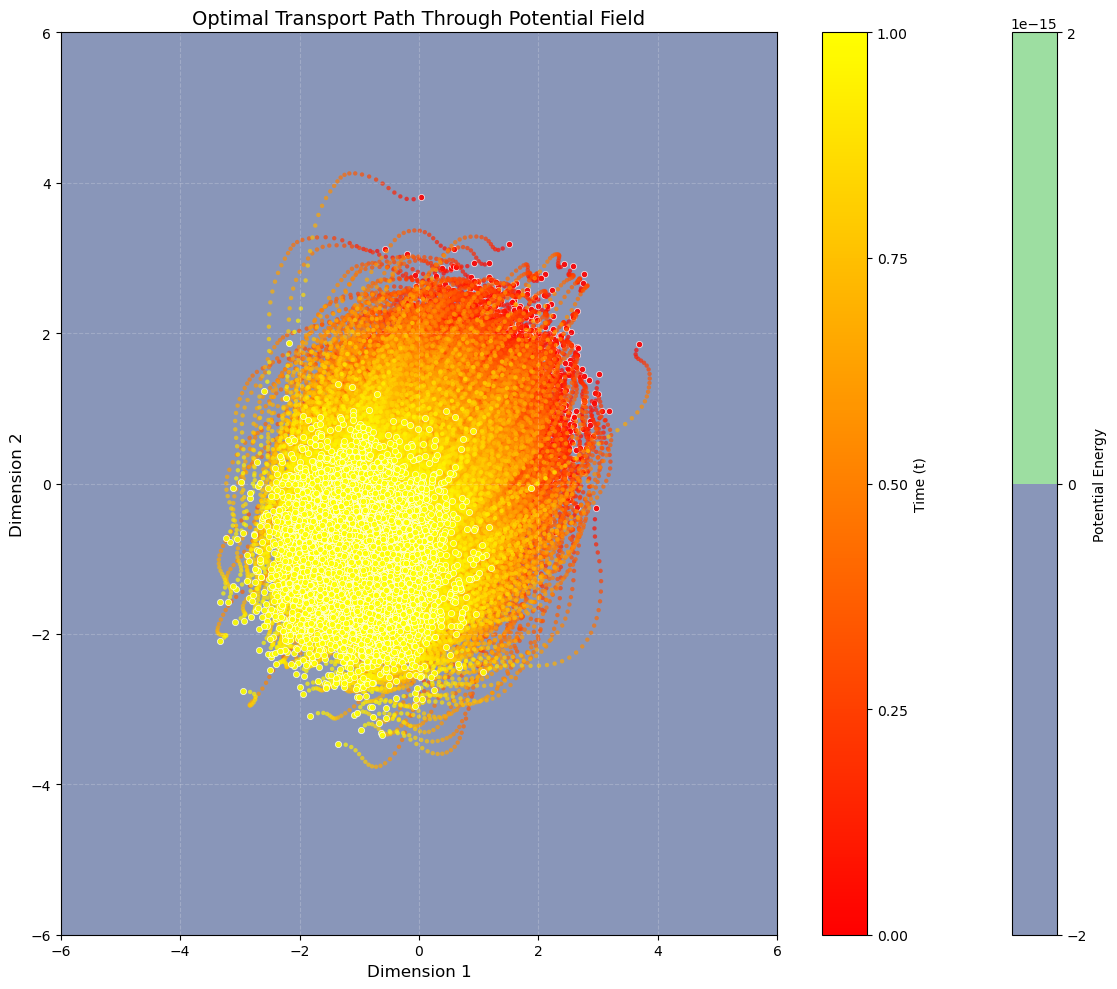

In [13]:

interpolation0 = spline0(s)
samples_path0 = path_visualization(interpolation=interpolation0,arch = arch,
spline = spline0,
x0 = config['visualization']['plot_bounds']['x_min'],
y0 = config['visualization']['plot_bounds']['y_min'],
x1 = config['visualization']['plot_bounds']['x_max'],
y1 = config['visualization']['plot_bounds']['y_max'],
num_samples = 50,
time_steps = 10,solver = 'midpoint',
z = z0,num_contour_points = 100,idx_x = idx_x,idx_y = idx_y)

In [14]:
mean_t,cov_t = estimate_mean_cov(samples_path0)
cov_0,cov_1 = cov_t[0],cov_t[-1]
mean_0,mean_1 = mean_t[0],mean_t[-1]
print(W2_gaussian(cov_0,cov_1,mean_0,mean_1)**2/2)
print(W2_gaussian(cov0,cov_0,mu0,mean_0))
print(W2_gaussian(cov1,cov_1,mu1,mean_1))



tensor(100.5339, device='cuda:3', dtype=torch.float64)
tensor(0.7625, device='cuda:3', dtype=torch.float64)
tensor(0.4956, device='cuda:3', dtype=torch.float64)


In [15]:

if spline0.fisher_pot and not spline0.entropy_pot:
    norm_socre0,samples_path0 = spline0.gen_sample_trajectory(z0,num_samples=len(z0),t_traj=s,time_steps_node=10,solver='midpoint')
    entropy = None
elif spline0.entropy_pot and not spline0.fisher_pot:
    entropy,samples_path0 = spline0.gen_sample_trajectory(z0,num_samples=len(z0),t_traj=s,time_steps_node=10,solver='midpoint')
    norm_score0 = None
elif spline0.entropy_pot and spline0.fisher_pot:
    entropy,norm_socre0,samples_path0 = spline0.gen_sample_trajectory(z0,num_samples=len(z0),t_traj=s,time_steps_node=10,solver='midpoint')
else:
    entropy = None
    norm_socre0 = None

lagrangian0,_,_ = spline0.lagrangian(samples_path0.to(device),s,log_density= entropy,score=norm_socre0)

print(lagrangian0)

tensor(4.4788, device='cuda:3', grad_fn=<AddBackward0>)


/work/Sebas/miniconda3/envs/PDPO/lib/python3.12/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


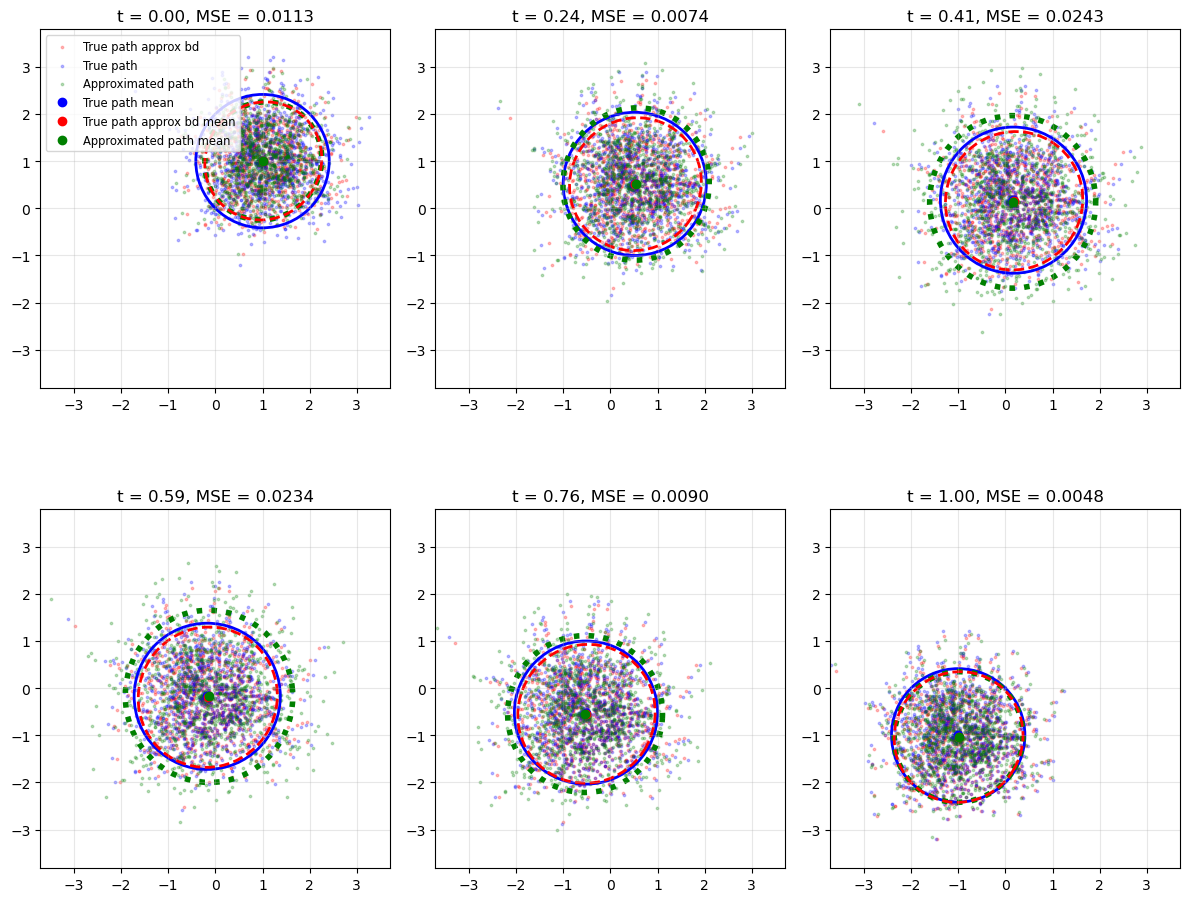

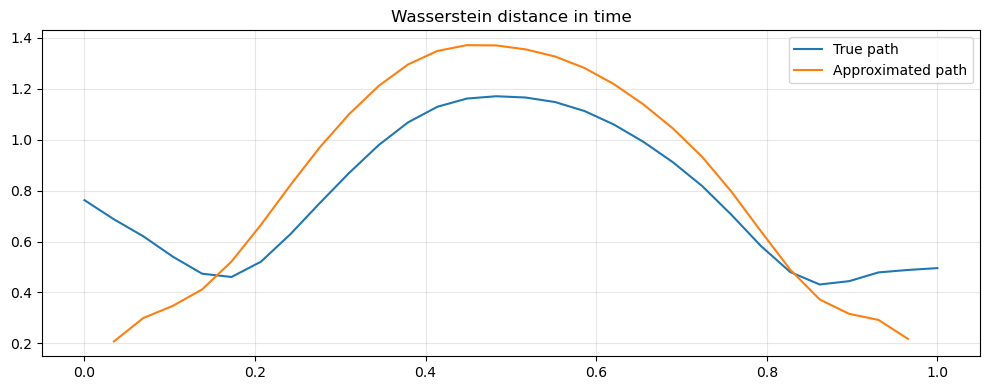

In [15]:
w2_error_true,w2_error_approx,w2_error_true_path,w2_error_approx_path = test_results_gaussian_SB(mu0,mu1,cov0,cov0,spline0.sigma,s,spline0,samples_path0.to(device),l2_errors = False,plot = True)

In [16]:
w2_error_true,w2_error_approx

(tensor(0.7762), tensor(0.7896))

In [17]:
w2_error_true_path,w2_error_approx_path

(tensor([0.7625, 0.6874, 0.6206, 0.5408, 0.4735, 0.4608, 0.5208, 0.6287, 0.7510,
         0.8696, 0.9785, 1.0680, 1.1294, 1.1616, 1.1707, 1.1658, 1.1480, 1.1128,
         1.0597, 0.9920, 0.9122, 0.8184, 0.7048, 0.5825, 0.4800, 0.4312, 0.4443,
         0.4788, 0.4883, 0.4956]),
 tensor([   nan, 0.2074, 0.2994, 0.3470, 0.4118, 0.5216, 0.6657, 0.8214, 0.9700,
         1.1005, 1.2110, 1.2955, 1.3488, 1.3715, 1.3704, 1.3549, 1.3270, 1.2819,
         1.2186, 1.1391, 1.0450, 0.9331, 0.7957, 0.6405, 0.4891, 0.3723, 0.3160,
         0.2920, 0.2174,    nan]))

In [19]:
results = np.array([204.7456,203.5621,203.9541])
np.mean(results),np.std(results)

(np.float64(204.08726666666666), np.float64(0.4922520244301261))